# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize

In [3]:
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results" 
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

                                                text  \
0  id\n35152213\n742153090850164742\n149646300645...   
1  screen_name\tname\tid\tlocation\tfollowers_cou...   
2  id\n1424055675030806529\n1502717352575651840\n...   
3  screen_name\tname\tid\tlocation\tfollowers_cou...   

                                        cleaned_text  \
0  id 35152213 742153090850164742 149646300645197...   
1  screenname name id location followerscount fri...   
2  id 1424055675030806529 1502717352575651840 150...   
3  screenname name id location followerscount fri...   

                                              tokens  
0  [id, 35152213, 742153090850164742, 14964630064...  
1  [screenname, name, id, location, followerscoun...  
2  [id, 1424055675030806529, 1502717352575651840,...  
3  [screenname, name, id, location, followerscoun...  
There are 3995237 tokens in the data.
There are 3995216 unique tokens in the data.
There are 45692021 characters in the data.
The lexical diversity is 1.000 in the

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(4, 10996014)
(4, 10996014)


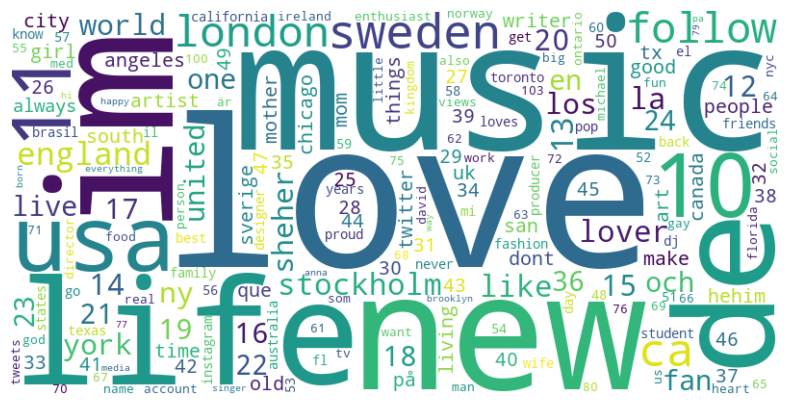

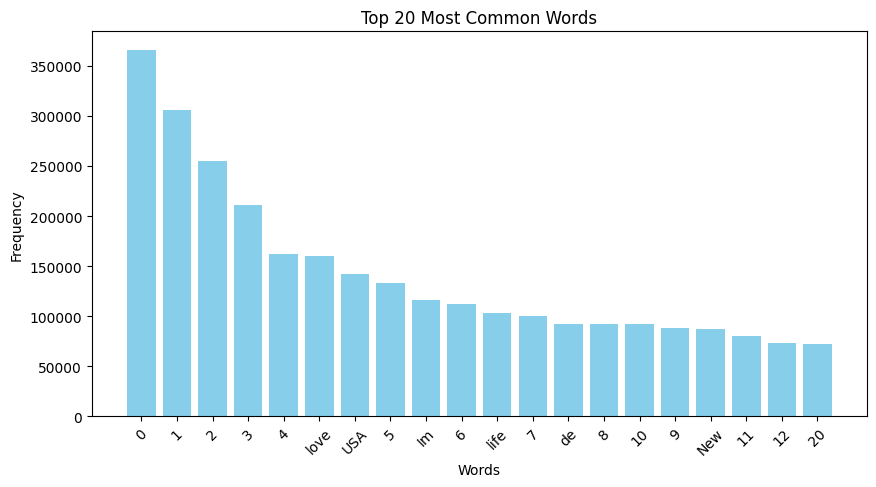

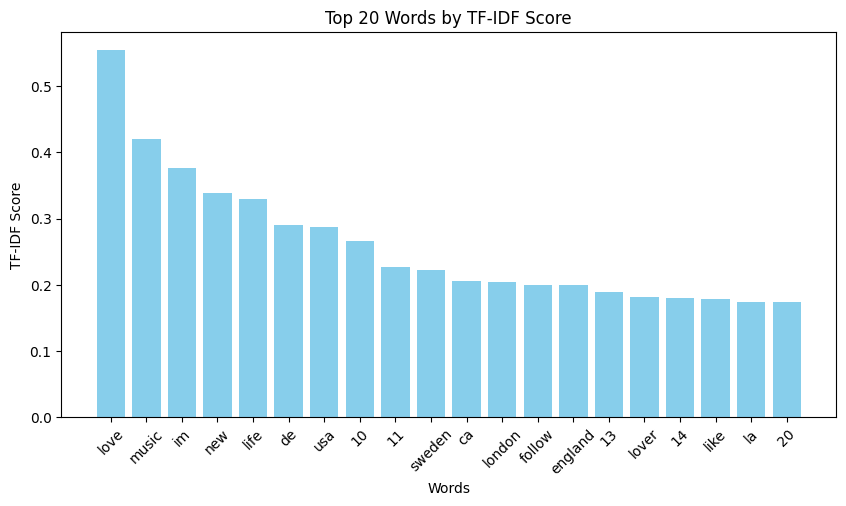

In [4]:
# Punctuation set excluding hashtag
tw_punct = set(punctuation) - {"#"}

# Stopwords
sw = stopwords.words("english")

# Regex patterns
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Set of all emojis
all_language_emojis = set()
for country in emoji.EMOJI_DATA:
    for em in emoji.EMOJI_DATA[country]:
        all_language_emojis.add(em)

# Functions

def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print number of tokens, number of unique tokens, 
    number of characters, lexical diversity, and num_tokens most common tokens. 
    Return a list with the number of tokens, number of unique tokens, lexical diversity, and number of characters.
    """
    num_tokens_total = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = len(''.join(tokens))
    lexical_diversity = num_unique_tokens / num_tokens_total if num_tokens_total > 0 else 0
    
    if verbose:
        print(f"There are {num_tokens_total} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
        if num_tokens > 0:
            counts = Counter(tokens)
            print(counts.most_common(num_tokens))
    
    return [num_tokens_total, num_unique_tokens, num_characters, lexical_diversity]

def contains_emoji(s):
    """
    Check if a string contains any emojis.
    """
    s = str(s)
    emojis = [ch for ch in s if ch in all_language_emojis]
    return len(emojis) > 0

def remove_stop(tokens):
    """
    Remove stopwords from a list of tokens.
    """
    return [token for token in tokens if token.lower() not in sw]

def remove_punctuation(text, punct_set=tw_punct):
    """
    Remove punctuation from a string.
    """
    return ''.join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    """
    Tokenize a string by splitting on whitespace.
    """
    return whitespace_pattern.split(text)

def prepare(text, pipeline):
    """
    Process a string through a series of transformation functions.
    """
    tokens = str(text)
    
    for transform in pipeline:
        tokens = transform(tokens)
    
    return tokens

# Function to read text files from a directory
def read_text_files(directory):
    texts = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Assuming the files are .txt
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
    return texts

# Define paths
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

# Read text files from both directories
twitter_texts = read_text_files(os.path.join(data_location, twitter_folder))
lyrics_texts = read_text_files(os.path.join(data_location, lyrics_folder))

# Combine all texts into a single DataFrame
all_texts = twitter_texts + lyrics_texts
df = pd.DataFrame(all_texts, columns=['text'])

# Preprocess and tokenize text
df['tokens'] = df['text'].apply(lambda x: prepare(x, [remove_punctuation, tokenize, remove_stop]))
df['cleaned_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

# Verify the preprocessing and tokenization
print(df[['text', 'cleaned_text', 'tokens']].head())

# Example processing for a sample text
sample_text = df['text'].iloc[0]
tokens = prepare(sample_text, [remove_punctuation, tokenize, remove_stop])
stats = descriptive_stats(tokens, verbose=True)
emoji_presence = contains_emoji(sample_text)

print("Processed tokens:", tokens)
print("Contains emoji:", emoji_presence)

# Vectorization using CountVectorizer
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(df['cleaned_text'])
print(X_counts.shape)

# Apply TF-IDF transformation
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)

# Generate word cloud
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.sum(axis=0).A1
word_scores = dict(zip(feature_names, tfidf_scores))

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_scores)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Flatten tokens and calculate word frequencies
all_tokens = [token for tokens in df['tokens'] for token in tokens]
word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)

word_freq_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

plt.figure(figsize=(10, 5))
plt.bar(word_freq_df['word'], word_freq_df['frequency'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

# Sum TF-IDF scores and plot
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf': tfidf_scores})
top_tfidf_df = tfidf_df.nlargest(20, 'tfidf')

plt.figure(figsize=(10, 5))
plt.bar(top_tfidf_df['word'], top_tfidf_df['tfidf'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title('Top 20 Words by TF-IDF Score')
plt.xticks(rotation=45)
plt.show()

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [5]:
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results" 
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [6]:
# Define the file path
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

# Define the artist file
artist_files = {'cher': 'cher_followers_data.txt'}

# Read the CSV file into a DataFrame
file_path = os.path.join(data_location, twitter_folder, artist_files['cher'])
twitter_data = pd.read_csv(file_path, sep="\t", quoting=3)

# Add an 'artist' column
twitter_data['artist'] = "cher"


In [7]:
# Define the file paths
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results"
twitter_folder = "twitter/"

# Function to read text files from a directory
def read_text_files_from_directory(directory):
    texts = []
    print(f"Reading from directory: {directory}")
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return texts
    for filename in os.listdir(directory):
        if filename.startswith("cher_followers"):  # Adjusted to match the file names
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
        elif filename.startswith("robynkonichiwa_followers"):  # Adjusted to match the file names
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
    return texts

# Read Twitter data for Cher
cher_followers = read_text_files_from_directory(os.path.join(data_location, twitter_folder))

# Read Twitter data for Robyn
robyn_followers = read_text_files_from_directory(os.path.join(data_location, twitter_folder))

# Concatenate the data into a single DataFrame
twitter_data = pd.concat([
    pd.DataFrame({'text': cher_followers, 'artist': 'cher'}),
    pd.DataFrame({'text': robyn_followers, 'artist': 'robyn'})
], ignore_index=True)

# Remove intermediate variables
del cher_followers, robyn_followers


Reading from directory: C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results\twitter/
Reading from directory: C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results\twitter/


In [8]:
# Define the file paths
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results"
lyrics_folder = "lyrics/"

# Function to read text files from a directory
def read_text_files_from_directory(directory):
    texts = []
    print(f"Reading from directory: {directory}")
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return texts
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts

# Read lyrics data for Cher
cher_lyrics = read_text_files_from_directory(os.path.join(data_location, lyrics_folder, 'cher'))

# Read lyrics data for Robyn
robyn_lyrics = read_text_files_from_directory(os.path.join(data_location, lyrics_folder, 'robyn'))

# Display a sample of the ingested data
print("Sample of Cher lyrics data:")
for data in cher_lyrics[:3]:
    print(data[:100])  # Display the first 100 characters

print("\nSample of Robyn lyrics data:")
for data in robyn_lyrics[:3]:
    print(data[:100])  # Display the first 100 characters


Reading from directory: C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results\lyrics/cher
Reading from directory: C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results\lyrics/robyn
Sample of Cher lyrics data:
"88 Degrees"



Stuck in L.A., ain't got no friends 
And so Hollywood nuts, 
Too many dead ends 
Lif
"A Different Kind Of Love Song"



What if the world was crazy and I was sane
Would it be so strange
"After All"



Well, here we are again
I guess it must be fate
We've tried it on our own
But deep in

Sample of Robyn lyrics data:
"88 Days"



I light a candle in the morning 
To signify that your still on my mind
Darkness arrived
"Ain't No Thing"



[Verse 1:]
Boy you gotta want me, really really want me
Boy you gotta need me ca
"Anytime You Like"



It's like you're waiting for me to start
There's no right moment to break my h


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [9]:
import os

# Define function to read text files from a directory
def read_text_files_from_folder(folder_path):
    texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):  # Assuming the files are .txt
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
    return texts

# Define the pipeline of text processing functions
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_folder_path = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results\lyrics"
twitter_folder_path = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results\twitter"


# Read text files from both folders
lyrics_texts = read_text_files_from_folder(lyrics_folder_path)
twitter_texts = read_text_files_from_folder(twitter_folder_path)

# Apply the pipeline to each text in the lyrics folder
lyrics_tokens = [prepare(text, pipeline=my_pipeline) for text in lyrics_texts]
lyrics_num_tokens = [len(tokens) for tokens in lyrics_tokens]

# Apply the pipeline to each text in the twitter folder
twitter_tokens = [prepare(text, pipeline=my_pipeline) for text in twitter_texts]
twitter_num_tokens = [len(tokens) for tokens in twitter_tokens]


In [10]:
twitter_data['has_emoji'] = twitter_data["text"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [11]:
# Compute the 'has_emoji' column
twitter_data['has_emoji'] = twitter_data['text'].apply(contains_emoji)

# Tokenize the 'text' column
twitter_data['tokens'] = twitter_data['text'].apply(prepare, pipeline=my_pipeline)

# Sample rows where 'has_emoji' is True and select specific columns
sample_with_emoji = twitter_data[twitter_data['has_emoji']].sample(min(10, sum(twitter_data['has_emoji'])), replace=True)[['artist', 'text', 'tokens']]


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One area of improvement to my tokenization I could thoretically carry out would be handling hyphenated words. Depending on the word and what meaning it can bring to the text, it might be preferable to treat hyphenated words as single tokens.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [32]:
import os
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

# Define paths
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results"
lyrics_folder = "lyrics"  # Assuming the folder containing lyrics is named 'lyrics'

# Function to read text files from a folder
def read_text_files_from_folder(folder_path):
    texts = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):  # Assuming the files are .txt
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
                filenames.append(filename)
    return texts, filenames

# Read text files for Cher
cher_folder = os.path.join(data_location, lyrics_folder, 'cher')
cher_lyrics, cher_filenames = read_text_files_from_folder(cher_folder)

# Read text files for Robyn
robyn_folder = os.path.join(data_location, lyrics_folder, 'robyn')
robyn_lyrics, robyn_filenames = read_text_files_from_folder(robyn_folder)

# Combine lyrics and filenames for both artists
all_lyrics = cher_lyrics + robyn_lyrics
all_filenames = cher_filenames + robyn_filenames

# Determine artist from filenames
artists = ['cher' if 'cher' in filename.lower() else 'robyn' for filename in all_filenames]

# Create a DataFrame for lyrics data
lyrics_data = pd.DataFrame({
    'text': all_lyrics,
    'artist': artists
})

print(lyrics_data.head())  # Display the first few rows to verify

                                                text artist
0  "88 Degrees"\n\n\n\nStuck in L.A., ain't got n...   cher
1  "A Different Kind Of Love Song"\n\n\n\nWhat if...   cher
2  "After All"\n\n\n\nWell, here we are again\nI ...   cher
3  "Again"\n\n\n\nAgain evening finds me at your ...   cher
4  "Alfie"\n\n\n\nWhat's it all about, Alfie?\nIs...   cher


In [34]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Ensure the stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Define paths
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week 2\M1 Results"
lyrics_folder = "lyrics"  # Assuming the folder containing lyrics is named 'lyrics'

# Function to read text files from a folder
def read_text_files_from_folder(folder_path):
    texts = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):  # Assuming the files are .txt
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
                filenames.append(filename)
    return texts, filenames

# Read text files for Cher
cher_folder = os.path.join(data_location, lyrics_folder, 'cher')
cher_lyrics, cher_filenames = read_text_files_from_folder(cher_folder)

# Read text files for Robyn
robyn_folder = os.path.join(data_location, lyrics_folder, 'robyn')
robyn_lyrics, robyn_filenames = read_text_files_from_folder(robyn_folder)

# Combine lyrics and filenames for both artists
all_lyrics = cher_lyrics + robyn_lyrics
all_filenames = cher_filenames + robyn_filenames

# Determine artist from filenames
artists = ['cher' if 'cher' in filename.lower() else 'robyn' for filename in all_filenames]

# Create a DataFrame for lyrics data
lyrics_data = pd.DataFrame({
    'text': all_lyrics,
    'artist': artists
})

# Define the text processing functions
def remove_stop(tokens):
    sw = set(stopwords.words("english"))
    return [token for token in tokens if token.lower() not in sw]

def remove_punctuation(text, punct_set=set(punctuation)):
    return ''.join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    return word_tokenize(text)

def prepare(text, pipeline):
    for transform in pipeline:
        text = transform(text)
    return text

# Simplified pipeline with debugging output
def apply_pipeline(text):
    processed_text = prepare(text, my_pipeline)
    return processed_text

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Apply the pipeline to the lyrics data
lyrics_data['tokens'] = lyrics_data['text'].apply(apply_pipeline)

print(lyrics_data.head())  # Display the first few rows to verify


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\keevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\keevi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


                                                text artist  \
0  "88 Degrees"\n\n\n\nStuck in L.A., ain't got n...   cher   
1  "A Different Kind Of Love Song"\n\n\n\nWhat if...   cher   
2  "After All"\n\n\n\nWell, here we are again\nI ...   cher   
3  "Again"\n\n\n\nAgain evening finds me at your ...   cher   
4  "Alfie"\n\n\n\nWhat's it all about, Alfie?\nIs...   cher   

                                              tokens  
0  [88, degrees, stuck, la, aint, got, friends, h...  
1  [different, kind, love, song, world, crazy, sa...  
2  [well, guess, must, fate, weve, tried, deep, i...  
3  [evening, finds, door, ask, could, try, dont, ...  
4  [alfie, whats, alfie, moment, live, whats, sor...  


In [35]:
def descriptive_stats(tokens_list, num_tokens=5, verbose=True):
    """
    Given a list of lists of tokens, print number of tokens, number of unique tokens, 
    number of characters, lexical diversity, and num_tokens most common tokens. 
    Return a list with the number of tokens, number of unique tokens, lexical diversity, and number of characters.
    """
    all_tokens = [token for tokens in tokens_list for token in tokens]
    num_tokens_total = len(all_tokens)
    num_unique_tokens = len(set(all_tokens))
    num_characters = sum(len(token) for token in all_tokens)
    lexical_diversity = num_unique_tokens / num_tokens_total if num_tokens_total > 0 else 0
    
    if verbose:
        print(f"There are {num_tokens_total} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
        if num_tokens > 0:
            counts = Counter(all_tokens)
            print(counts.most_common(num_tokens))
    
    return [num_tokens_total, num_unique_tokens, num_characters, lexical_diversity]

# Separate lyrics data by artist
cher_lyrics = lyrics_data[lyrics_data['artist'] == 'cher']['tokens']
robyn_lyrics = lyrics_data[lyrics_data['artist'] == 'robyn']['tokens']

# Calculate descriptive statistics for Cher
print("Descriptive Statistics for Cher's Lyrics:")
stats_cher = descriptive_stats(cher_lyrics, verbose=True)

# Calculate descriptive statistics for Robyn
print("\nDescriptive Statistics for Robyn's Lyrics:")
stats_robyn = descriptive_stats(robyn_lyrics, verbose=True)

# Compare the results
print("\nComparison of Descriptive Statistics:")
print(f"Cher - Number of tokens: {stats_cher[0]}, Number of unique tokens: {stats_cher[1]}, Lexical diversity: {stats_cher[3]:.3f}")
print(f"Robyn - Number of tokens: {stats_robyn[0]}, Number of unique tokens: {stats_robyn[1]}, Lexical diversity: {stats_robyn[3]:.3f}")

Descriptive Statistics for Cher's Lyrics:
There are 36371 tokens in the data.
There are 3703 unique tokens in the data.
There are 172544 characters in the data.
The lexical diversity is 0.102 in the data.
[('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('got', 352)]

Descriptive Statistics for Robyn's Lyrics:
There are 15430 tokens in the data.
There are 2155 unique tokens in the data.
There are 73783 characters in the data.
The lexical diversity is 0.140 in the data.
[('know', 308), ('dont', 301), ('im', 299), ('got', 276), ('love', 275)]

Comparison of Descriptive Statistics:
Cher - Number of tokens: 36371, Number of unique tokens: 3703, Lexical diversity: 0.102
Robyn - Number of tokens: 15430, Number of unique tokens: 2155, Lexical diversity: 0.140


Q: what observations do you make about these data? 

A: Looking at the statistics for Cher's and Robyn's lyrics, it can be seen there are twice the number of tokens in Cher's lyrics. This shows that the dataset of Cher's is larger either because there are more songs or the songs are longer. Cher's lyrics also contain more unique tokens. The lexical diversity difference suggests, Robyn's vocabulary is more diverse.

Cher might have a larger volume of lyrics with more repetition, but Robyn's lyrics shows it is more varied with a larger vocabulary.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [37]:
from collections import defaultdict

# Function to calculate concentration ratio
def calculate_concentration_ratio(corpus_tokens):
    concentration_ratio = defaultdict(float)
    total_tokens = sum(corpus_tokens.values())
    
    for token, count in corpus_tokens.items():
        concentration_ratio[token] = count / total_tokens
    
    return concentration_ratio

# Function to find unique tokens for each corpus
def find_unique_tokens(corpus_tokens, other_corpora_tokens, min_occurrences=5, top_n=10):
    unique_tokens = []
    
    # Calculate concentration ratio for the corpus
    corpus_concentration = calculate_concentration_ratio(corpus_tokens)
    
    # Calculate concentration ratios for other corpora
    other_corpora_concentration = []
    for other_tokens in other_corpora_tokens:
        other_corpora_concentration.append(calculate_concentration_ratio(other_tokens))
    
    # Find unique tokens
    for token, ratio in corpus_concentration.items():
        if corpus_tokens[token] >= min_occurrences:
            max_ratio = max(cr[token] for cr in other_corpora_concentration)
            if ratio > max_ratio:
                unique_tokens.append((token, ratio))
    
    # Sort unique tokens by ratio
    unique_tokens.sort(key=lambda x: x[1], reverse=True)
    
    return unique_tokens[:top_n]

# Example usage with Cher and Robyn corpora
cher_tokens = Counter([token for tokens in cher_lyrics for token in tokens])
robyn_tokens = Counter([token for tokens in robyn_lyrics for token in tokens])

# Find unique tokens for Cher compared to Robyn
cher_unique_tokens = find_unique_tokens(cher_tokens, [robyn_tokens])

# Find unique tokens for Robyn compared to Cher
robyn_unique_tokens = find_unique_tokens(robyn_tokens, [cher_tokens])

print("Unique tokens for Cher compared to Robyn:")
for token, ratio in cher_unique_tokens:
    print(f"{token}: {ratio:.5f}")

print("\nUnique tokens for Robyn compared to Cher:")
for token, ratio in robyn_unique_tokens:
    print(f"{token}: {ratio:.5f}")


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Observations that I can make of the top tokens are that the token love for Cher is over three times larger
the size of the next token time. This would suggest that Chers songs focus on the theme of love.
The tokens for Robyn are all used closely equal to each other. the top four being know
dont, im, and got. These would suggest more of a conversational tone. 

An interesting item in Robyns list of unique tokens is the token Na. This could represent
a lyrical motif, a sound, or vocalization. 

The observations made show there is thematic and stylistic differences between the two
artists. The tokens give an insight into lyrical approaches and themes.

Unique tokens for Cher compared to Robyn:
love: 0.02760
time: 0.00877
see: 0.00847
oh: 0.00841
one: 0.00775
go: 0.00753
come: 0.00742
take: 0.00723
heart: 0.00715
way: 0.00608

Unique tokens for Robyn compared to Cher:
know: 0.01996
dont: 0.01951
im: 0.01938
got: 0.01789
like: 0.01504
baby: 0.01439
na: 0.01167
youre: 0.01095
never: 0.01005
dance: 0.00972


## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [44]:
pip install wordcloud nltk

Note: you may need to restart the kernel to use updated packages.


Word Cloud for Cher's Lyrics


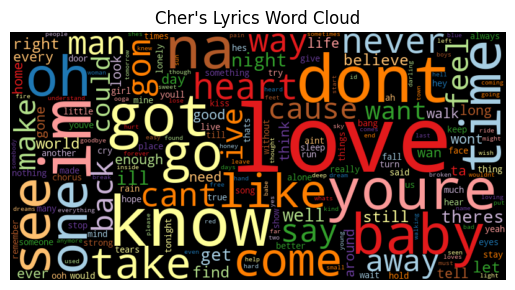

Word Cloud for Robyn's Lyrics


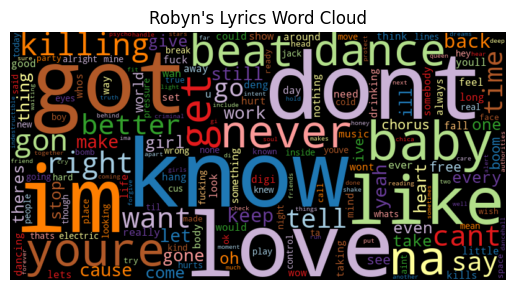

In [45]:
from collections import Counter
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Define the wordcloud function
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, 
                   background_color="black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # Convert data frame into dict
    if isinstance(word_freq, pd.Series):
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # Filter stopwords in frequency counter
    if stopwords is not None:
        counter = {token: freq for token, freq in counter.items() 
                   if token not in stopwords}
    
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
# Define the count_words function
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # Create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

# Example usage with Cher and Robyn lyrics data
stop_words = set(stopwords.words('english'))

# Calculate word frequencies for Cher
cher_freq_df = count_words(lyrics_data[lyrics_data['artist'] == 'cher'])

# Calculate word frequencies for Robyn
robyn_freq_df = count_words(lyrics_data[lyrics_data['artist'] == 'robyn'])

# Generate word cloud for Cher
print("Word Cloud for Cher's Lyrics")
wordcloud(cher_freq_df['freq'], title="Cher's Lyrics Word Cloud", stopwords=stop_words)

# Generate word cloud for Robyn
print("Word Cloud for Robyn's Lyrics")
wordcloud(robyn_freq_df['freq'], title="Robyn's Lyrics Word Cloud", stopwords=stop_words)


Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The word clouds created for Cher and Robyn's lyrics show a visual representation of the most frequent words. These help to highlight the differences and similarities in the lyrical themes. It can be seen in Cher's sound cloud, words such as love, time, baby, youre, heart, and come, can idicate that love, possibly romanace and emotions are themes to Cher's music.

The words that are dominant in Robyn's word cloud are dont, know, love, got, like and never. Self-expression and relationships seems to be indicated as themes for her songs. Her words seem more coversational in style, Words like baby and like suggest a informal or intimate tone.

Word clouds are a useful tool to help visualize and compare styles. The word clouds produced for Cher and Robyn provide a straightforward look at their lyrical content.